# Jingle Jangle 
### Tables on Content
1. Data Exploration/Visualisation  
&nbsp;&nbsp;&nbsp;&nbsp;1.1 Data Exploration of Class, Time, Amount  
&nbsp;&nbsp;&nbsp;&nbsp;1.2 Distribution of 29 features - Penny VS non-penny Frauds
  
2. Data Cleaning  
  
3. Model  
&nbsp;&nbsp;&nbsp;&nbsp;3.1 Model  
&nbsp;&nbsp;&nbsp;&nbsp;3.2 Hyperparameter Optimisation  
&nbsp;&nbsp;&nbsp;&nbsp;3.3 Model Training  
&nbsp;&nbsp;&nbsp;&nbsp;3.4 Model Evaluation  

*To run and test model, please follow the following steps:*  
1) Load datasets and do the splits [Dtype: pandas.DataFrame] (train VS test) & (val VS target)  
2) Pass the train and test datasets into preprocessing_data(data) separately --> No data leak  
3) Pass the train data into SMOTEnsemble(train_val, target). A list of XGBoost will be returned.  
4) Pass the list into ensemble_predict(test_data, list_of_classifiers). A numpy array holding predictions from each weak classifier will be returned.   
5) Pass the prediction np array into ensemble_predict(predictions, test_target, ensemble_threshold) <-- Please refer to last plot in this notebook to understand tradeoff between Recall and Precision. Covered in PPT Slides.  


In [1]:
import pandas as pd
import numpy as np

# Visualisation 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer # Used in preprocessing_data
import random # Used in equal_split

# Model
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE # Placed here instead of 'Preprocessing' 
                                         # because SMOTE is only done after subset split

# Parameter Optimisation
import xgboost as xgb
from sklearn import metrics # Metrics for Optimisation
from sklearn.metrics import recall_score
from sklearn.metrics.scorer import make_scorer # Custom score
from sklearn.model_selection import GridSearchCV # Grid Search

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read csv file
filename = 'creditcard-training set v2.csv'

dataset = pd.read_csv(open(filename, 'r'))
data_target = dataset['Fraud? (1: Fraud, 0:  No Fraud)']
data_value = dataset.drop('Fraud? (1: Fraud, 0:  No Fraud)', axis=1) # Drop fraud label for data
data_value = data_value.drop('Seconds since reference time', axis=1) 

## 1. Data Exploration/Visualisation

### Data Exploration of Class, Time and Amount
#### Class Distribution

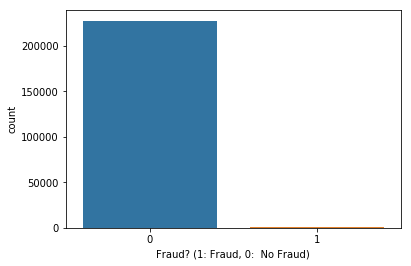

In [3]:
sns.countplot('Fraud? (1: Fraud, 0:  No Fraud)', data=dataset, palette= "tab10")

#### Amount Distribution

(0.0, 800)

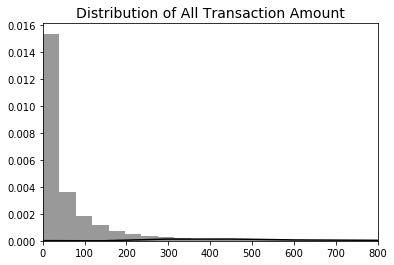

In [4]:
amount_val = dataset['Amount'].values

fig_amt1 = sns.distplot(amount_val, color = 'black', bins = 500)
fig_amt1.set_title('Distribution of All Transaction Amount', fontsize=14)
fig_amt1.set_xlim([min(amount_val), 800])

(0.0, 800)

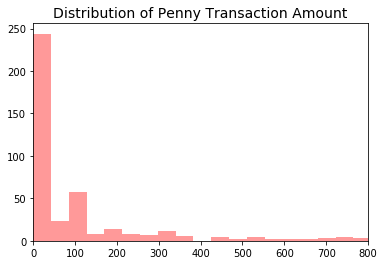

In [5]:
amount_val = dataset[dataset["Fraud? (1: Fraud, 0:  No Fraud)"] == 1]['Amount'].values
fig_amt2 = sns.distplot(amount_val, color='r', bins = 50, kde = False)
fig_amt2.set_title('Distribution of Penny Transaction Amount', fontsize=14)
fig_amt2.set_xlim([min(amount_val), 800])

(0.0, 800)

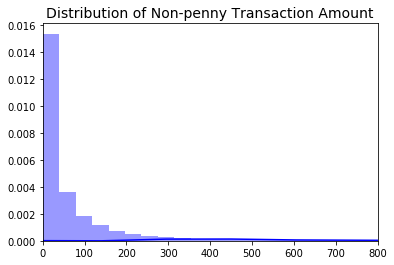

In [6]:
amount_val = dataset[dataset["Fraud? (1: Fraud, 0:  No Fraud)"] == 0]['Amount'].values

fig_amt3 = sns.distplot(amount_val, color='b', bins = 500, kde = True)
fig_amt3.set_title('Distribution of Non-penny Transaction Amount', fontsize=14)
fig_amt3.set_xlim([min(amount_val), 800])

#### Amount Distribution according to Time

(0.0, 40.34583333333333)

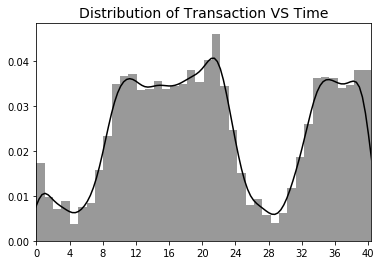

In [7]:
time_val = dataset['Seconds since reference time'].values / 3600

fig_time1 = sns.distplot(time_val, color='black', bins = 40)
fig_time1.set_title('Distribution of Transaction VS Time', fontsize=14)
fig_time1.xaxis.set_major_locator(plt.MultipleLocator(4))
fig_time1.set_xlim([min(time_val), max(time_val)])

(0.0, 40.34583333333333)

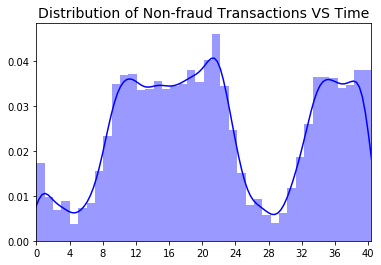

In [8]:
non_fraud_dataset = dataset[dataset['Fraud? (1: Fraud, 0:  No Fraud)'] == 0]
time_val = non_fraud_dataset['Seconds since reference time'].values / 3600

fig_time2 = sns.distplot(time_val, color='blue', bins = 40)
fig_time2.set_title('Distribution of Non-fraud Transactions VS Time', fontsize=14)
fig_time2.xaxis.set_major_locator(plt.MultipleLocator(4))
fig_time2.set_xlim([min(time_val), max(time_val)])

(0.11277777777777778, 40.23305555555555)

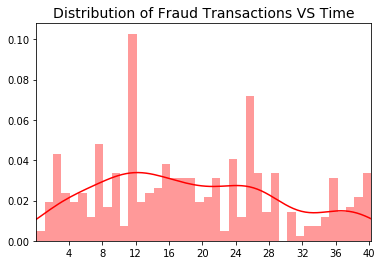

In [9]:
fraud_dataset = dataset[dataset['Fraud? (1: Fraud, 0:  No Fraud)'] == 1]
time_val = fraud_dataset['Seconds since reference time'].values / 3600

# Time
fig_time3 = sns.distplot(time_val, color='red', bins = 40)
fig_time3.set_title('Distribution of Fraud Transactions VS Time', fontsize=14)
fig_time3.xaxis.set_major_locator(plt.MultipleLocator(4))
fig_time3.set_xlim([min(time_val), max(time_val)])

#### Proportion of Penny VS Non-penny by Value

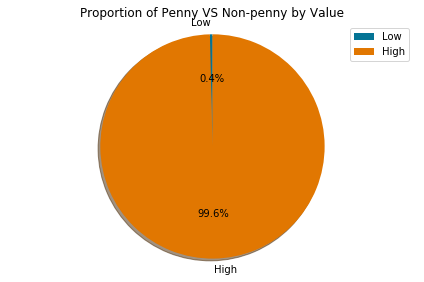

In [10]:
totallow = sum(dataset[(dataset["Amount"] < 5) & (dataset["Fraud? (1: Fraud, 0:  No Fraud)"] == 1)]["Amount"])
totalhigh = sum(dataset[(dataset["Amount"] >= 5) & (dataset["Fraud? (1: Fraud, 0:  No Fraud)"] == 1)]["Amount"])

labels = ['Low', 'High']
sizes = [totallow, totalhigh]
colors = [sns.xkcd_rgb["sea blue"], sns.xkcd_rgb["pumpkin"]]
a, patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, labels = labels, autopct='%1.1f%%')
plt.legend(patches, labels = labels, loc="best")
plt.axis('equal')
plt.title("Proportion of Penny VS Non-penny by Value")
plt.tight_layout()
plt.show()

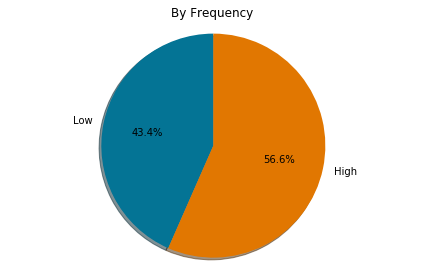

In [11]:
freqlow = len(dataset[(dataset['Amount'] < 5) & (dataset['Fraud? (1: Fraud, 0:  No Fraud)'] == 1)]['Amount'])
freqhigh = len(dataset[(dataset['Amount'] >= 5) & (dataset['Fraud? (1: Fraud, 0:  No Fraud)'] == 1)]['Amount'])

labels = ['Low', 'High']
sizes = [freqlow, freqhigh]
colors = [sns.xkcd_rgb['sea blue'], sns.xkcd_rgb['pumpkin']]
wedges, patches, texts = plt.pie(sizes, colors = colors,labels = labels, shadow=True, startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.title('By Frequency')
plt.tight_layout()
plt.show()

### 1.2 Distribution of 29 features - Penny VS non-penny Frauds

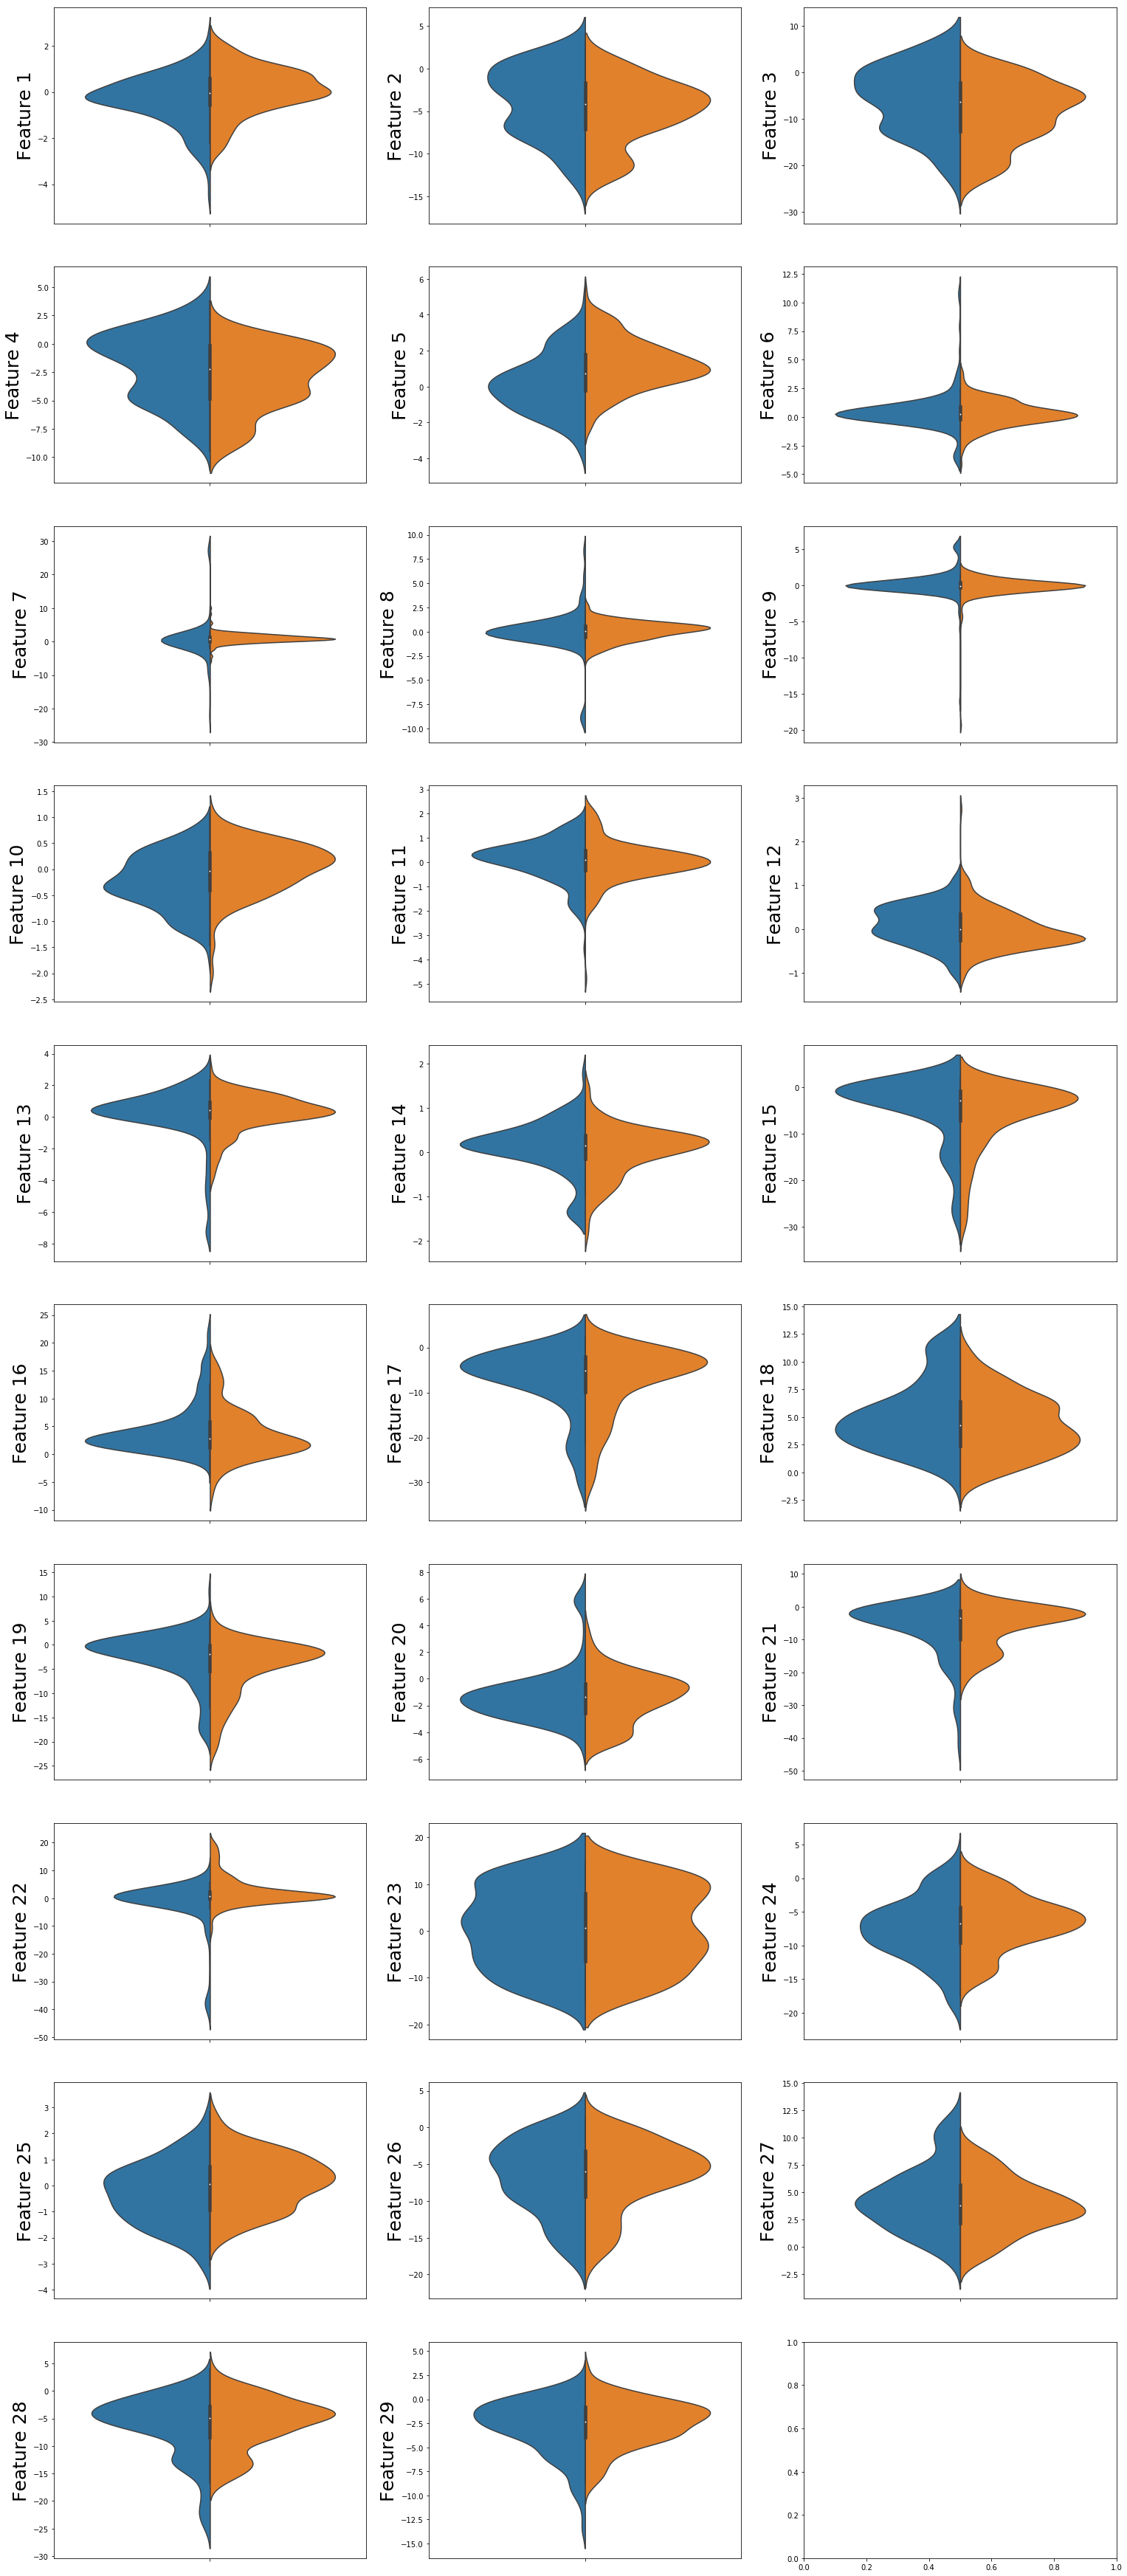

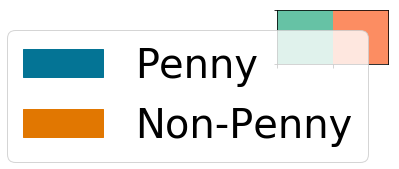

In [12]:
pd.options.mode.chained_assignment = None # Not required

# Select fraud data
fraud_dataset['tiered_fraud_value'] = pd.cut(fraud_dataset.Amount, [0, 5, max(fraud_dataset['Amount'])], include_lowest=True, 
                                        labels=['Penny', 'Non-Penny'])
fraud_dataset.reset_index(drop=True, inplace=True)

col_names = list(fraud_dataset.columns.values)
exclusions = ['Seconds since reference time','Amount', 'Fraud? (1: Fraud, 0:  No Fraud)', 'tiered_fraud_value']
y_vars = [x for x in col_names if x not in exclusions]

# Set distribution to empty string for visual purposes
fraud_dataset['all'] = ''
%matplotlib inline

f, axes = plt.subplots(10,3,figsize=(10.,60.))
plt.subplots_adjust(left= 1, bottom=0.1, right=3, top=0.9, wspace=0.2, hspace=0.2)

cmap = sns.palplot(sns.mpl_palette('Set2', 2))
for i in range(29):
    f = sns.violinplot(x="all", y=y_vars[i], hue="tiered_fraud_value",
                   data=fraud_dataset, palette= cmap, ax=axes[i//3][i%3], split= True)
    f.legend_.remove()
    f.set_xlabel("")
    f.set_ylabel("")
    f.set_ylabel("Feature " + str(i+1), fontsize = 25)

blue_patch = mpatches.Patch(color=sns.xkcd_rgb["sea blue"], label='Penny')
orange_patch = mpatches.Patch(color=sns.xkcd_rgb["pumpkin"], label='Non-Penny')

plt.legend(handles=[blue_patch, orange_patch], fontsize = 40)

## 2. Data Cleaning
To clean our data, we replaced NaN values with the column averages

In [13]:
# Replace NaN values with column averages
def preprocessing_data(data):
    imp = SimpleImputer() # Default parameters: missing_values='NaN', strategy='mean'
    data = imp.fit_transform(data)
    return data

In [14]:
# train_set:test_set = 80:20
train_data_value, test_data_value, train_data_target, test_data_target = train_test_split(data_value, data_target, train_size=0.8)

# train and test set processed separately
train_data_value = preprocessing_data(train_data_value)
test_data_value = preprocessing_data(test_data_value)

## 3. Model

In [15]:
# Splits the data into equal subsets with the same ratio of majority and minority class data points
# Only for 2 classes: 0 and 1. Used in SMOTEnsemble
def equal_split(data, target, num_set):
    # Split to class 0 and 1
    zero_class_data = data[target == 0]
    zero_class_target = target[target == 0]
    one_class_data = data[target == 1]
    one_class_target = target[target == 1]
    
    # Obtain lengths for each set
    zero_class_len = len(zero_class_data)
    num_zero_class_per_set = zero_class_len//num_set
    
    # Generating sets
    split_data = []
    for i in range(num_set):
        merged_dict = {}
        if not i == num_set - 1:
            # Select samples
            zero_class_indices = random.sample(range(len(zero_class_data)), num_zero_class_per_set)
            
            # Extract Samples
            zero_subset_data = np.array([zero_class_data[idx] for idx in zero_class_indices])
            zero_subset_target = np.array([zero_class_target[idx] for idx in zero_class_indices])
            
            # Removing data already added into subsets
            zero_class_data = np.delete(zero_class_data, zero_class_indices, 0)
            zero_class_target = np.delete(zero_class_target, zero_class_indices,0)
            
        else: # select all of the remaining data 
            zero_subset_data = zero_class_data
            zero_subset_target = zero_class_target
        
        # Merge dataset
        merged_subset_data = np.concatenate([zero_subset_data, one_class_data])
        merged_subset_target = np.concatenate([zero_subset_target, one_class_target])
        
        # Shuffle
        shuffle_idx = np.random.permutation(len(merged_subset_data))
        merged_subset_data, merged_subset_target = merged_subset_data[shuffle_idx], merged_subset_target[shuffle_idx]
        

        # Append subset
        merged_dict['data'] = merged_subset_data
        merged_dict['target'] = merged_subset_target
        split_data.append(merged_dict)    
        
    # split_data = list of {'data': subset_data, 'target': subset_target}
    return split_data

## 3 Model
Easy-SMT with XGBoost as classifer

### 3.1 Hyperparameter Optimisation
The hyperparameters are optimised using Grid Search (GridSearchCV).  

*Note: Some ranges are not equally spaced because a coarse search is done first before zooming into the range and doing further parameter optimisation*

The range of values for the following parameters are as follows:  
&nbsp;&nbsp;&nbsp;&nbsp;Max. Depth: [3, 5, 7, 8, **9**, 10, 11]  
&nbsp;&nbsp;&nbsp;&nbsp;Min. Child Weight: [**1**, 2, 3, 5]  
&nbsp;&nbsp;&nbsp;&nbsp;Gamma: [**0**, 0.1, 0.2, 0.3, 0.4]  
&nbsp;&nbsp;&nbsp;&nbsp;Subsample: [0.1, 0.2, 0.3, 0.4, **0.45**, 0.5, 0.6, 0.7, 0.8, 0.9]  
&nbsp;&nbsp;&nbsp;&nbsp;Column Sample by Tree: [0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 0.85, 0.9, **0.95**]  
&nbsp;&nbsp;&nbsp;&nbsp;Regularisation Alpha: [1e-5, 1e-2, **0.1**, 1, 100]

Final Optimised Values:  
&nbsp;&nbsp;&nbsp;&nbsp;Max. Depth: **9**  
&nbsp;&nbsp;&nbsp;&nbsp;Min. Child Weight: **1**  
&nbsp;&nbsp;&nbsp;&nbsp;Gamma: **0.0**  
&nbsp;&nbsp;&nbsp;&nbsp;Subsample: **0.45**  
&nbsp;&nbsp;&nbsp;&nbsp;Column Sample by Tree: **0.95**  
&nbsp;&nbsp;&nbsp;&nbsp;Regularisation Alpha: **0.1**

Due to the lack of processing power, we have used a progressive form of grid search and finetuning for optimisation.

In [16]:
# Custom score taking only minority recall into account
def minority_recall(pred, true):
    return recall_score(true, pred, average='binary', pos_label=1)

custom_score = make_scorer(minority_recall, greater_is_better=True)

In [17]:
# Split train set into 20 subsets for ensemble training
subset_values = equal_split(train_data_value, train_data_target.values, 20)

In [18]:
def model_fit(alg, data, label, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data, label=label)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(data, label,eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(data)
    dtrain_predprob = alg.predict_proba(data)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(label, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(label, dtrain_predprob))
    
    feat_imp = pd.DataFrame(data=[alg.feature_importances_])
    feat_imp.plot(kind='bar', title='Feature Importances', legend=None)
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 1
AUC Score (Train): 1.000000


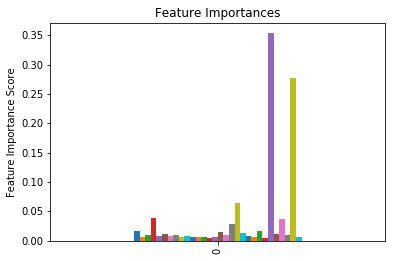

In [19]:
# Initial parameters for Model
xgb1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    sub_sample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = 1,
    objective = 'binary:logistic',
    nthread = 4,
    seed = 27, # Ensure Reproducability
)


# Obtain subset. Select 1st subset for parameter optimisation
subset_data = np.array(subset_values[0]['data'])
subset_target = np.array(subset_values[0]['target'])

# SMOTE subset
subset_data, subset_target = SMOTE().fit_resample(subset_data, subset_target)

model_fit(xgb1, subset_data, subset_target)

#### Grid Search (max_depth and min_child_weight)
max_depth: 9  
min_child_weight: 1 

In [20]:
param_test1 = {
    'max_depth':range(3,12,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
    param_grid = param_test1, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch1.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 12, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [21]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 9, 'min_child_weight': 1}
0.9974711357264988


#### Grid Search Finetuning (max_depth and min_child_weight)
max_depth: 9  
min_child_weight: 1

In [22]:
param_test2 = {
    'max_depth': [8,9,10],
    'min_child_weight': [1,2],
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=3,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring=custom_score,n_jobs=4,iid=False, cv=5)

gsearch2.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [8, 9, 10], 'min_child_weight': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [23]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'max_depth': 9, 'min_child_weight': 1}
0.9974711357264988


In [24]:
# Checking more ranges
param_test2b = {
    'min_child_weight':[7,9,11,13]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=1,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test2b, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch2b.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [25]:
print(gsearch2b.best_params_)
print(gsearch2b.best_score_)

# Not chosen since score is less than min_child_weight = 1

{'min_child_weight': 7}
0.9794772042062089


#### Grid Search (Gamma)
gamma: 0

In [26]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test3, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch3.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [27]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

{'gamma': 0.0}
0.9974711357264988



Model Report
Accuracy : 1
AUC Score (Train): 1.000000


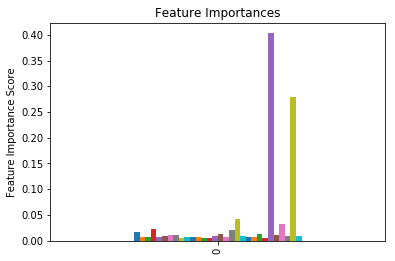

In [28]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=1,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
model_fit(xgb2, subset_data, subset_target)

#### Grid Search (subsample, colsample_bytree)
subsample: 0.45  
solsample_bytree: 0.95 

In [29]:
param_test4 = {
    'subsample':[i/10.0 for i in range(5,10)],
    'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
    min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test4, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch4.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [30]:
print(gsearch4.best_params_)
print(gsearch4.best_score_)

{'colsample_bytree': 0.5, 'subsample': 0.8}
0.997912750458781


#### Grid Search Checking More Values (subsample, solsample_bytree)

In [31]:
param_test4a = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(1,6)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
    min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test4a, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch4a.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [32]:
print(gsearch4a.best_params_)
print(gsearch4a.best_score_)

# Selected because score is higher than 1st search

{'colsample_bytree': 0.3, 'subsample': 0.8}
0.9985710652996556


#### Grid Search Finetuning (subsample, colsample_bytree)

In [34]:
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(25,40,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
    min_child_weight=1, gamma=0.0, subsample=0.6, colsample_bytree=0.6,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test5, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch5.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.6),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.25, 0.3, 0.35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [35]:
print(gsearch5.best_params_)
print(gsearch5.best_score_)

{'colsample_bytree': 0.3, 'subsample': 0.8}
0.9985710652996556


#### Grid Search (reg_alpha)

In [36]:
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
    min_child_weight=1, gamma=0.0, subsample=0.80, colsample_bytree=0.30,
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
    param_grid = param_test6, scoring=custom_score,n_jobs=4,iid=False, cv=5)
gsearch6.fit(subset_data,subset_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(minority_recall), verbose=0)

In [37]:
print(gsearch6.best_params_)
print(gsearch6.best_score_)

{'reg_alpha': 0.01}
0.9985713065501729


### 3.3 Model  + Training

In [38]:
def SMOTEnsemble(data, target, num_subset=20):
    # Split into multiple subsets
    split_data = equal_split(data, target, num_subset)

    # Save each weak booster in a list
    xgb_classifiers = []
    
    for i, subset_dict in enumerate(split_data):
        # Obtain subset
        subset_data = subset_dict['data']
        subset_target = subset_dict['target']

        # SMOTE different subsets
        subset_data, subset_target = SMOTE().fit_resample(subset_data, subset_target)
        
        print('Subset {}'.format(i+1))
        
        # Model Parameters. Selected through Grid Search + Cross Validation
        trained_model = XGBClassifier(
            learning_rate=0.1,
             n_estimators=1000,
             max_depth=9,
             min_child_weight=1,
             gamma=0.0,
             subsample=0.80,
             colsample_bytree=0.30,
             reg_alpha=0.01,
             objective='binary:logistic',
             nthread=4,
             scale_pos_weight=1,
             seed=27
        )
        
        # Fit model according to subset train data
        trained_model.fit(subset_data, subset_target)
        
        xgb_classifiers.append(trained_model)

    # Return classifiers
    return xgb_classifiers

In [39]:
num_set = 20
ensemble_classifiers = SMOTEnsemble(train_data_value, train_data_target.values, num_subset=num_set)

Subset 1
Subset 2
Subset 3
Subset 4
Subset 5
Subset 6
Subset 7
Subset 8
Subset 9
Subset 10
Subset 11
Subset 12
Subset 13
Subset 14
Subset 15
Subset 16
Subset 17
Subset 18
Subset 19
Subset 20


### 3.4 Model Evaluation
The model is evaluated using Recall and Precision

In [40]:
def ensemble_predict(data, classifiers):
    data_length = len(data)
    for i, classifier in enumerate(classifiers):
        if i == 0:
            predictions = np.array(classifier.predict(data))
        else:
            predictions = np.concatenate([predictions, np.array(classifier.predict(data))])
    predictions = np.reshape(predictions, (len(classifiers), data_length))
    predictions = np.transpose(predictions)
    return predictions

In [45]:
def ensemble_results(ensemble_predictions, test_data_target, ensemble_threshold):
    # Predict test dataset
    target = test_data_target.values

    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for k, pred in enumerate(ensemble_predictions):
        if sum(pred) > ensemble_threshold:
            if target[k] == 1:
                tp += 1
            else:
                fp += 1
        if sum(pred) <= ensemble_threshold:
            if target[k] == 0:
                tn += 1
            else:
                fn += 1
    recall = 100*tp/(tp+fn)
    precision = 100*(tp)/(tp+fp)
    print('Precision: {} %, Recall: {} %'.format(precision, recall))

    print('True Positive: {}\nTrue Negative: {}\nFalse Positive: {}\nFalse Negative: {}'.format(tp,tn,fp,fn))
    return [recall, precision]

In [46]:
ensemble_predictions = ensemble_predict(test_data_value, ensemble_classifiers)

In [49]:
recall_prec = []
for i in range(num_set):
    print('\nEnsemble Threshold: {}'.format(i+1)) # Ensemble threshold in the slides are defined 
                                                  # slightly differently (i VS i+1)
    recall_prec.append(ensemble_results(ensemble_predictions, test_data_target, ensemble_threshold=i))


Ensemble Threshold: 1
Precision: 26.408450704225352 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45279
False Positive: 209
False Negative: 6

Ensemble Threshold: 2
Precision: 32.751091703056765 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45334
False Positive: 154
False Negative: 6

Ensemble Threshold: 3
Precision: 35.046728971962615 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45349
False Positive: 139
False Negative: 6

Ensemble Threshold: 4
Precision: 38.46153846153846 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45368
False Positive: 120
False Negative: 6

Ensemble Threshold: 5
Precision: 40.32258064516129 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45377
False Positive: 111
False Negative: 6

Ensemble Threshold: 6
Precision: 41.899441340782126 %, Recall: 92.5925925925926 %
True Positive: 75
True Negative: 45384
False Positive: 104
False Negative: 6

Ensemble Threshold: 7
Precision: 42.52873

#### Evolution of Precision and Accuracy VS Ensemble Threshold
Ensemble threshold: number of weak classifiers agreeing to a positive fraud before the ensemble model outputs a positive fraud

(0, 100)

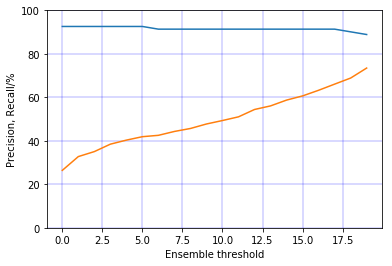

In [48]:
plt.plot(recall_prec)
plt.ylabel('Precision, Recall/%')
plt.xlabel('Ensemble threshold')
plt.grid(which='both', color='b', linestyle='-', linewidth=0.3)
plt.ylim(0,100)